# Importing Libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

# Fetching Dataset

In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip

--2022-04-19 20:25:54--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.90.240
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.90.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3745528792 (3.5G) [application/octet-stream]
Saving to: ‘9xkhgts2s6-1.zip’

9xkhgts2s6-1.zip    100%[===================>]   3.49G  97.9MB/s    in 37s     

2022-04-19 20:26:32 (95.6 MB/s) - ‘9xkhgts2s6-1.zip’ saved [3745528792/3745528792]



# Unzipping Dataset

In [3]:
%%capture
!unzip 9xkhgts2s6-1.zip

# Setting Directories and Hyperparameters

In [4]:
image_directory='Curated X-Ray Dataset/Curated X-Ray Dataset/'

no_covid_images=os.listdir(image_directory+ 'Normal/')
yes_covid_images=os.listdir(image_directory+ 'COVID-19/')

dataset=[]
label=[]

INPUT_SIZE=128

# Processing Dataset

In [5]:
for i , image_name in tqdm(enumerate(no_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Normal/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in tqdm(enumerate(yes_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'COVID-19/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

3270it [01:55, 28.41it/s]
1281it [00:54, 23.47it/s]


In [6]:
dataset=np.array(dataset)
label=np.array(label)

# Splitting Training and Validation Data

In [7]:
x_train, x_split, y_train, y_split = train_test_split(dataset, label, test_size=0.3, random_state=0)

x_train=tf.keras.utils.normalize(x_train, axis=1)
y_train=tf.keras.utils.to_categorical(y_train , num_classes=2)

# Splitting Validation and Testing Data

In [8]:
x_test, x_val, y_test, y_val = train_test_split(x_split, y_split, test_size=0.33, random_state=0)

x_val = tf.keras.utils.normalize(x_val, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

y_val = tf.keras.utils.to_categorical(y_val , num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=2)

# Setting Base Model

In [9]:
base_model = VGG19(input_shape=(128, 128, 3), weights='imagenet', include_top=False, pooling='max')

for layer in base_model.layers:
    layer.trainable = False

2022-04-19 20:30:21.014689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 20:30:21.119025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 20:30:21.119794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 20:30:21.121030: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


# Building Model Architecture

In [10]:
input = base_model.input

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# Plotting Function

In [11]:
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()

# Model Summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

# Compiling Model

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='SGD', metrics=['accuracy'])

# Training

In [14]:
%%time
history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    verbose=1, epochs=500, 
    validation_data=(x_val, y_val)
    )

2022-04-19 20:30:34.458972: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 626196480 exceeds 10% of free system memory.
2022-04-19 20:30:35.159682: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 626196480 exceeds 10% of free system memory.
2022-04-19 20:30:35.670112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-19 20:30:37.190872: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 12s 45ms/step - loss: 0.4550 - accuracy: 0.7793 - val_loss: 0.3033 - val_accuracy: 0.9335
Epoch 2/500
100/100 [==============================] - 3s 31ms/step - loss: 0.2978 - accuracy: 0.8926 - val_loss: 0.2338 - val_accuracy: 0.9335
Epoch 3/500
100/100 [==============================] - 3s 31ms/step - loss: 0.2520 - accuracy: 0.9089 - val_loss: 0.2186 - val_accuracy: 0.9290
Epoch 4/500
100/100 [==============================] - 3s 31ms/step - loss: 0.2330 - accuracy: 0.9162 - val_loss: 0.2002 - val_accuracy: 0.9246
Epoch 5/500
100/100 [==============================] - 3s 32ms/step - loss: 0.2167 - accuracy: 0.9206 - val_loss: 0.2466 - val_accuracy: 0.9069
Epoch 6/500
100/100 [==============================] - 3s 31ms/step - loss: 0.2073 - accuracy: 0.9199 - val_loss: 0.1962 - val_accuracy: 0.9113
Epoch 7/500
100/100 [==============================] - 3s 32ms/step - loss: 0.1959 - accuracy: 0.9228 - val_loss: 0.1909 - val_accuracy: 0.9135
Epo

# Evaluating Model

In [15]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

2022-04-19 20:57:34.322232: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 179896320 exceeds 10% of free system memory.
2022-04-19 20:57:34.530712: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 179896320 exceeds 10% of free system memory.


29/29 [==============================] - 2s 53ms/step - loss: 0.0486 - accuracy: 0.9869
Test loss:  0.048593390733003616
Accuracy:  0.9868852496147156


# Saving History

In [16]:
history.history

{'loss': [0.45503419637680054,
  0.2977941334247589,
  0.25199055671691895,
  0.23298001289367676,
  0.21672993898391724,
  0.20727738738059998,
  0.19592507183551788,
  0.1965295374393463,
  0.19213728606700897,
  0.18126340210437775,
  0.18376602232456207,
  0.18046298623085022,
  0.18325553834438324,
  0.1818045675754547,
  0.17301250994205475,
  0.16913245618343353,
  0.17261150479316711,
  0.16769030690193176,
  0.16823184490203857,
  0.16618621349334717,
  0.16507329046726227,
  0.15575486421585083,
  0.15995483100414276,
  0.1559847891330719,
  0.1556350737810135,
  0.15460555255413055,
  0.14949531853199005,
  0.150938481092453,
  0.15101677179336548,
  0.15403224527835846,
  0.15300686657428741,
  0.14216728508472443,
  0.14677941799163818,
  0.1399783194065094,
  0.1382569521665573,
  0.13942044973373413,
  0.1427677422761917,
  0.13719505071640015,
  0.13207411766052246,
  0.14013713598251343,
  0.13869808614253998,
  0.1348145455121994,
  0.1343524008989334,
  0.13314938545

# Plotting Curves

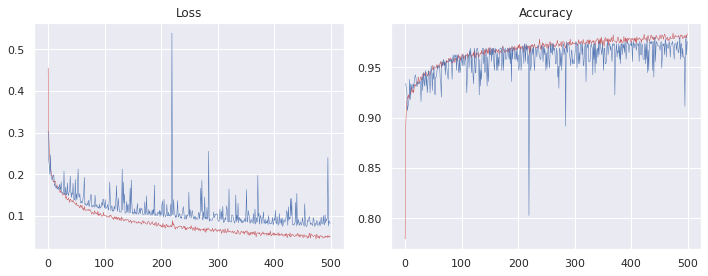

In [17]:
plot(history.history)

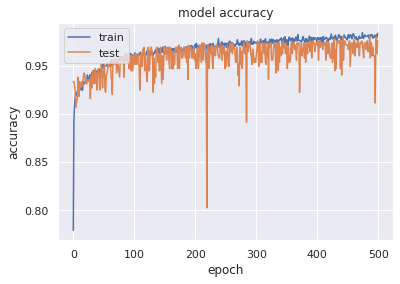

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

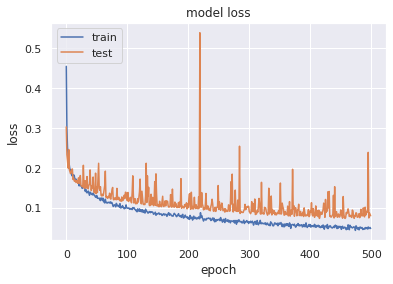

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
%%time
model.predict(x_train)

2022-04-19 20:59:42.317215: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 626196480 exceeds 10% of free system memory.


CPU times: user 3.26 s, sys: 1.48 s, total: 4.74 s
Wall time: 4.59 s


array([[9.9999964e-01, 3.9195848e-07],
       [8.3054658e-03, 9.9169451e-01],
       [9.9979609e-01, 2.0394784e-04],
       ...,
       [9.9951041e-01, 4.8957521e-04],
       [9.6517998e-01, 3.4819990e-02],
       [1.0000000e+00, 1.0559443e-08]], dtype=float32)

In [21]:
%%time
y_pred = model.predict(x_test)

CPU times: user 927 ms, sys: 236 ms, total: 1.16 s
Wall time: 1.66 s


In [22]:
Y_pred = np.argmax(y_pred, axis=1)

In [23]:
Y_test = np.argmax(y_test, axis=1)

In [24]:
Y_test  

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [25]:
Y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
%%time
result = model.predict(x_test[[0]])

CPU times: user 210 ms, sys: 926 µs, total: 211 ms
Wall time: 216 ms


In [27]:
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[677   7]
 [  5 226]]
Accuracy :  0.9868852459016394
Sensitivity :  0.9897660818713451
Specificity :  0.9783549783549783


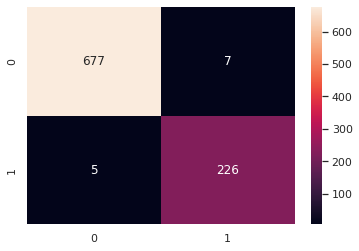

In [28]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

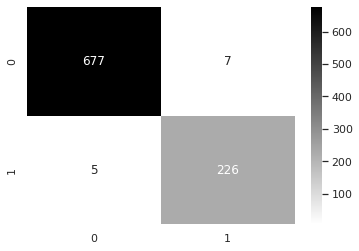

In [29]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="binary",annot=True,fmt="d")

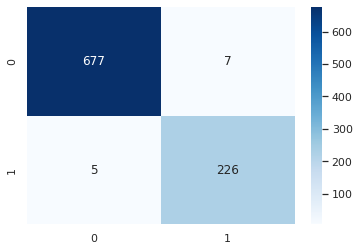

In [30]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="Blues", annot=True,fmt="d")

In [31]:
print(classification_report(Y_test, Y_pred, target_names = ['NORMAL', 'COVID']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       684
       COVID       0.97      0.98      0.97       231

    accuracy                           0.99       915
   macro avg       0.98      0.98      0.98       915
weighted avg       0.99      0.99      0.99       915



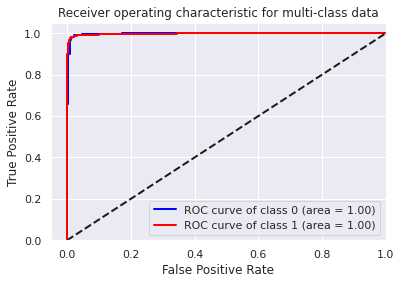

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [33]:
def display_training_curves(history, name, model_name, EPOCHS = 500):
    '''
    Plots the training process
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,15))
    fig.suptitle(model_name, size=20)
    
    # plot AUC
    ax1.plot(np.arange(EPOCHS),history.history['accuracy'],'-o',
             label='train',color='#ff7f0e')
    ax1.plot(np.arange(EPOCHS),history.history['val_accuracy'],'-o',
             label='val',color='#1f77b4')
    x = np.argmax(history.history['val_accuracy']); y = np.max(history.history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    ax1.scatter(x,y,s=200,color='#1f77b4')
    ax1.text(x-0.03*xdist,y-0.05*ydist,'max accuracy\n%.2f'%y,size=14)
    ax1.set_ylabel('Accuracy',size=14); ax1.set_xlabel('Epoch',size=14)
    ax1.set_title('Accuracy')
    ax1.set_xticks(list(range(EPOCHS)))
    ax1.set_xticklabels(list(range(1, EPOCHS+1)))
    ax1.legend(loc=2)

    #  plot loss
    ax2.plot(np.arange(EPOCHS),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    ax2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin(history.history['val_loss'] )
    y = np.min(history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    ax2.scatter(x,y,s=200,color='#d62728')
    ax2.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    ax2.set_ylabel('Loss',size=14); ax2.set_xlabel('Epoch',size=14)
    ax2.set_title('Loss')
    ax2.set_xticks(list(range(EPOCHS)))
    ax2.set_xticklabels(list(range(1, EPOCHS+1)))
    ax2.legend(loc=3)
    plt.savefig(name + '.png')
    plt.show() 

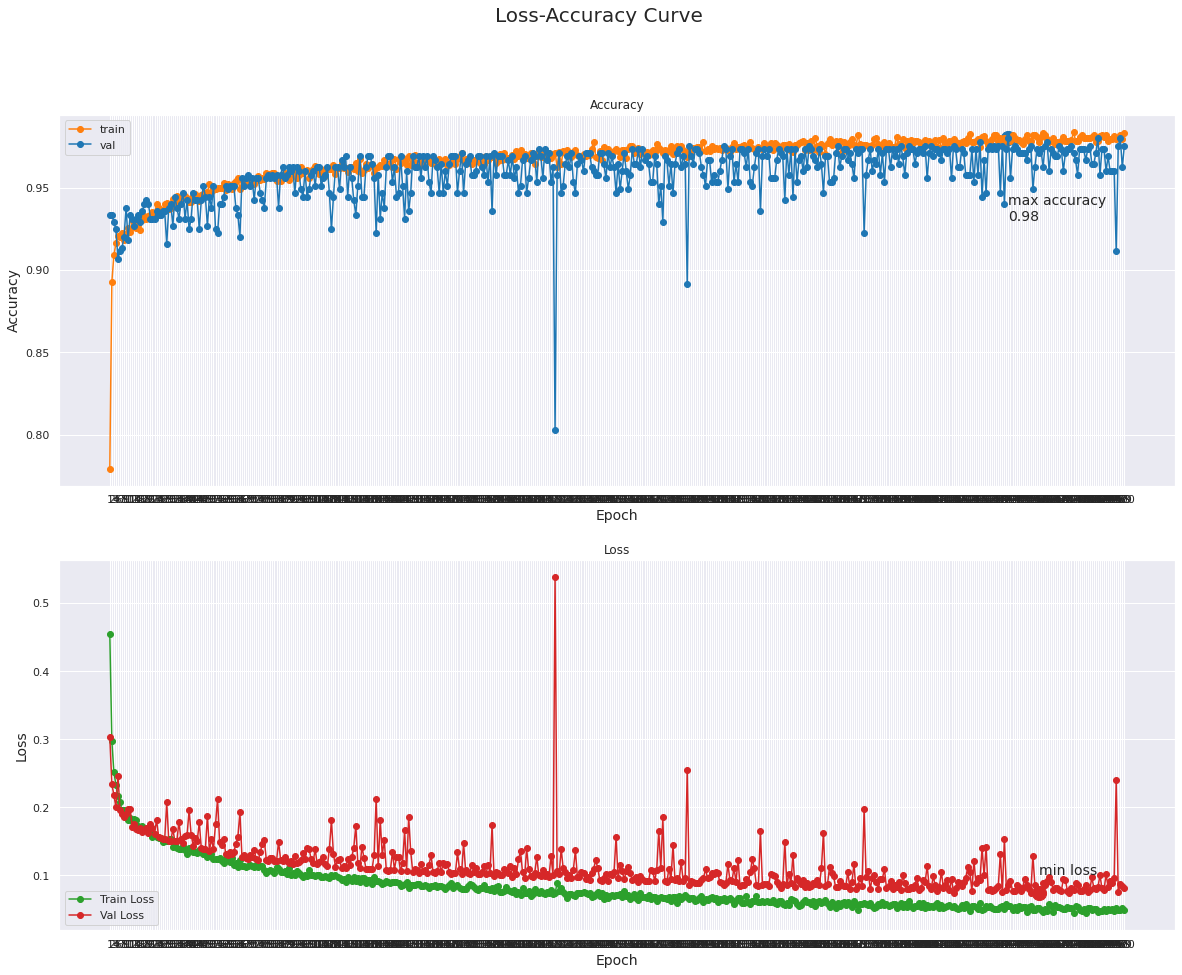

In [34]:
display_training_curves(history, 'name', 'Loss-Accuracy Curve')